In [54]:
# Let's create a simple torch model

import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt

torch.manual_seed(41)

class SimpleModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=128):
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Normalize the input
        x = x / 255.0
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc4(x)
        return x

In [55]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import pandas as pd
# import matplotlib.pyplot as plt

# torch.manual_seed(41)

# class SimpleLModel(nn.Module):
#     def __init__(self, input_size, output_size, hidden_size=128):
#         super(SimpleModel, self).__init__()
#         self.hidden_size = hidden_size
#         self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
#         self.fc = nn.Linear(hidden_size, output_size)

#     def forward(self, x):
#         # Normalize the input
#         x = x / 255.0
#         lstm_out, _ = self.lstm(x)
#         # Take only the output of the last time step
#         lstm_out = lstm_out[:, -1, :]
#         out = self.fc(lstm_out)
#         return out

# # Example usage:
# # model = SimpleLSTMModel(input_size=10, output_size=1)
# # print(model)

In [56]:
class Stock:
    def __init__(self, name, path = "stocks"):
        self.name = name
        self.df = pd.read_csv(f"{path}/{name}.csv")

    def __str__(self):
        return f'{self.name}'
    
    def enforce_timeframe(self, start_date, end_date):
        # Check to see if the timeframe is within the range of the dataframe
        if start_date < self.df['Date'].min():
            raise ValueError(f"{self.name} - Start date {start_date} is before the start of the dataframe {self.df['Date'].min()}")
        if end_date > self.df['Date'].max():
            raise ValueError(f"{self.name} - End date {end_date} is after the end of the dataframe {self.df['Date'].max()}")
        self.df = self.df[(self.df['Date'] >= start_date) & (self.df['Date'] <= end_date)]
    
    def simple(self, keep_date = False):
        # remove the date column and Adj Close
        # make a copy
        copied = self.df.copy()
        if not keep_date:
            copied = copied.drop(columns=['Date'])
        copied = copied.drop(columns=['Adj Close'])
        # Drop volume
        copied = copied.drop(columns=['Volume'])
        # Switch the Close and Volume columns
        close = copied.pop("Close")
        # Insert at the end of the dataframe
        copied.insert(len(copied.columns), "Close", close)

        # Add the name of the stock to the columns, all except date
        copied.columns = [f"{self.name}_{col}" if col != 'Date' else col for col in copied.columns]

        return copied
    
    def print_date_range(self):
        print(f"Date range for {self.name}: {self.df['Date'].min()} to {self.df['Date'].max()}")

    def get_timeframe(self):
        # Print out the start and end dates of the df
        print(f"Date range for {self.name}: {self.df['Date'].min()} to {self.df['Date'].max()}")
        return self.df['Date'].min(), self.df['Date'].max()
        

In [57]:
class StockMarket:
    def __init__(self, stocks : list):
        self.stocks = stocks

    def __str__(self):
        return f'{self.stocks}'

    def split(self, train_size=0.8, simple = None):
        # Split the data into training and testing
        if type(simple) == type(None):
            simple = self.simple()

        train_size = int(train_size * len(simple))
        train_data = simple.iloc[:train_size]
        test_data = simple.iloc[train_size:]

        assert len(train_data) + len(test_data) == len(simple)
        assert len(train_data) > 0

        # Get the number of features
        number_of_features = len(train_data.columns)

        X_train = train_data.iloc[:, :-1]
        y_train = train_data.iloc[:, -1]

        X_test = test_data.iloc[:, :-1]
        y_test = test_data.iloc[:, -1]

        return X_train, y_train, X_test, y_test, number_of_features

    def simple(self, keep_date = False):
        # Merge all the stock dataframes
        for stock in self.stocks:
            stock : Stock = stock
            if stock == self.stocks[0]:
                df = stock.simple(True)
            else:
                df = pd.merge(df, stock.simple(True), on='Date', how='inner')

        if not keep_date:
            df = df.drop(columns=['Date'])

        return df
    
    def plot(self):
        simple = self.simple()

        # Plot only using the close columns
        simple.filter(like='Close').plot()

    def info(self):
        # Print the start and end date of the simple dataframe
        simple = self.simple(keep_date=True)
        # Get the date using "like"
        start_date = simple.filter(like='Date').iloc[0][0]
        end_date = simple.filter(like='Date').iloc[-1][0]
        print(f"Start date: {start_date}")
        print(f"End date: {end_date}")
    
    def enforce_timeframe(self, start_date, end_date):
        # See if the start/end dates violate the range of the stocks
        for stock in self.stocks:
            stock : Stock = stock
            stock.enforce_timeframe(start_date, end_date)

    def append(self, stock):
        # Push it to the front of the list
        self.stocks.insert(0, stock)

    @classmethod
    def get_timeframe(cls, stocks):
        # Get the timeframe of the stocks
        for stock in stocks:
            stock.print_date_range()

        # Print out the best start and end dates
        start_date = max([stock.df['Date'].min() for stock in stocks])
        end_date = min([stock.df['Date'].max() for stock in stocks])

        print(f"Best start date: {start_date}")
        print(f"Best end date: {end_date}")

    @classmethod
    def enforce_timeframe_single(cls, df, start_date, end_date):
        return df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

In [58]:
amd = Stock("AMD")
amd.enforce_timeframe("2000-01-01", "2015-01-01")
amd.get_timeframe()

Date range for AMD: 2000-01-03 to 2014-12-31


('2000-01-03', '2014-12-31')

In [59]:
market = StockMarket([Stock("AMD")])
market.enforce_timeframe("2000-01-01", "2015-01-01")

In [60]:
Stock("AMD").simple(True).head()

,Date,AMD_Open,AMD_High,AMD_Low,AMD_Close
0,1980-03-17,0.0,3.302083,3.125000,3.145833
1,1980-03-18,0.0,3.125000,2.937500,3.031250
2,1980-03-19,0.0,3.083333,3.020833,3.041667
3,1980-03-20,0.0,3.062500,3.010417,3.010417
4,1980-03-21,0.0,3.020833,2.906250,2.916667


In [61]:
market = StockMarket([Stock("TSM"), Stock("NVDA"), Stock("AAPL"), Stock("MSFT"), Stock("ORCL"), Stock("INTC"), Stock("IBM"), Stock("AMD")])
StockMarket.get_timeframe(market.stocks)

Date range for TSM: 1997-10-09 to 2020-04-01
Date range for NVDA: 1999-01-22 to 2020-04-01
Date range for AAPL: 1980-12-12 to 2020-04-01
Date range for MSFT: 1986-03-13 to 2020-04-01
Date range for ORCL: 1986-03-12 to 2020-04-01
Date range for INTC: 1980-03-17 to 2020-04-01
Date range for IBM: 1962-01-02 to 2020-04-01
Date range for AMD: 1980-03-17 to 2020-04-01
Best start date: 1999-01-22
Best end date: 2020-04-01


In [62]:
x_train, y_train, x_test, y_test, features = market.split()
x_test

,TSM_Open,TSM_High,TSM_Low,TSM_Close,NVDA_Open,NVDA_High,NVDA_Low,NVDA_Close,AAPL_Open,AAPL_High,...,INTC_High,INTC_Low,INTC_Close,IBM_Open,IBM_High,IBM_Low,IBM_Close,AMD_Open,AMD_High,AMD_Low
4266,21.660000,21.709999,21.260000,21.340000,32.349998,32.500000,31.160000,31.530001,100.559998,102.370003,...,33.520000,32.799999,33.080002,134.380005,135.580002,133.619995,135.169998,2.660000,2.710000,2.470000
4267,20.879999,21.379999,20.820000,21.100000,30.740000,30.950001,29.879999,30.280001,98.680000,100.129997,...,33.009998,31.840000,31.840000,133.699997,135.020004,132.429993,132.860001,2.430000,2.480000,2.260000
4268,21.270000,21.400000,20.770000,20.809999,30.670000,30.700001,29.570000,29.629999,98.550003,99.110001,...,32.220001,31.430000,31.510000,133.179993,133.820007,131.320007,131.630005,2.360000,2.420000,2.100000
4269,21.170000,21.250000,20.700001,20.930000,29.660000,29.889999,29.150000,29.680000,98.970001,99.059998,...,32.220001,31.680000,32.060001,131.809998,133.820007,131.759995,133.229996,2.160000,2.360000,2.120000
4270,21.230000,21.240000,20.510000,20.750000,30.209999,30.620001,29.969999,30.180000,100.550003,100.690002,...,32.889999,32.270000,32.680000,133.649994,133.779999,131.130005,132.899994,2.400000,2.460000,2.280000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5328,49.099998,50.459999,48.919998,49.869999,253.940002,262.220001,250.000000,257.239990,246.520004,258.679993,...,55.950001,51.660000,55.540001,106.910004,113.150002,105.570000,112.889999,45.779999,47.500000,45.400002
5329,47.230000,48.090000,46.509998,46.910000,250.000000,263.119995,248.679993,252.729996,252.750000,255.869995,...,54.639999,52.070000,52.369999,108.580002,111.500000,107.650002,108.029999,46.320000,47.980000,45.900002
5330,47.180000,48.160000,46.770000,47.820000,255.360001,265.959991,253.589996,265.589996,250.740005,255.520004,...,56.099998,52.830002,55.490002,108.089996,113.459999,107.809998,112.930000,47.240002,48.459999,46.660000
5331,47.799999,49.029999,47.660000,47.790001,267.200012,275.399994,257.750000,263.600006,255.600006,262.489990,...,55.799999,53.220001,54.119999,112.000000,113.809998,110.169998,110.930000,47.930000,48.529999,45.160000


In [63]:
# I want to create a LSTM model that predicts the next day's closing price
# to do this, I intend to take in the previous 5 days' metrics (open, high, low, close, volume)
# and predict the next day's closing price

import os
import sys
from colorama import Fore
import numpy as np
from scipy.signal import savgol_filter
from scipy.signal import find_peaks

class DynamicModel:
    def __init__(self, number_of_days = 5, number_of_features=5, path = None, name = "default_model", hidden_size = 50, days_ahead = 1, batch_size = 50):

        # Makes it so that the model's input size is the number of features times the number of days
        self.dataset = None
        self.model = SimpleModel(input_size = number_of_features * number_of_days, output_size=1, hidden_size=hidden_size)
        if path:
            self.model.load_state_dict(torch.load(path))
        self.criterion = nn.MSELoss() # Mean Squared Error
        # self.criterion = nn.L1Loss() # Mean Absolute Error
        # self.criterion = nn.SmoothL1Loss()
        
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.number_of_features = number_of_features
        self.number_of_days = number_of_days
        self.losses = []
        self.predictions = []
        self.name = name
        self.accuracy = 0
        self.days_ahead = days_ahead    
        self.batch_size = batch_size

        self.title = None

    def info(self):
        print(f"Model: {self.model}")
        print(f"Optimizer: {self.optimizer}")
        print(f"Number of features: {self.number_of_features}")
        print(f"Number of days: {self.number_of_days}")
        print(f"Batch size: {self.batch_size}")

    def get_random_set(self, x_train, y_train):
        # Get a random batch of data
        # This will consider the number of days
        # it should also make sure that whatever index it chooses is not out of bounds

        random_index = np.random.randint(0, len(x_train) - self.number_of_days - self.days_ahead)

        x_batch = x_train.iloc[random_index:random_index + self.number_of_days]
        # y batch should just be the next day's closing price
        y_batch = y_train.iloc[random_index + self.number_of_days + self.days_ahead]

        x_batch = torch.tensor(x_batch.values).float().flatten()
        y_batch = torch.tensor(y_batch).float().flatten()

        return x_batch, y_batch


    def train(self, x_train, y_train, epochs):
        # Train the model
        self.losses = []

        # Pull the column name of the y_train
        self.title = y_train.name

        # Print the column name of the y_train
        print(f"Predicting: {y_train.name}")

        for epoch in range(epochs + 1):
            # Get a random batch of data
            rolling_loss = 0
            loss = 0
            for i in range(self.batch_size):
                x_batch, y_batch = self.get_random_set(x_train, y_train)

                # Forward pass
                y_out = self.model.forward(x_batch)

                # Calculate the loss
                loss = self.criterion(y_out, y_batch)

                # Backward pass
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                # save the rolling loss
                rolling_loss += loss.item()

                # Print out a comparison of the predicted and actual values every 10 epochs
                if epoch % 10 == 0:
                    self.print_inline(f"Epoch: {epoch} Loss: {loss.item()} Predicted: \
                                      {y_out.item()} Actual: {y_batch.item()}")

            self.losses.append(rolling_loss)

        print(f"{Fore.GREEN}\nTraining complete{Fore.RESET}")

    def validate(self, x_test, y_test):
        # Validate the model
        # Run the model with the x_test data
        # and compare it to the y_test data

        correct = 0

        for i in range(len(x_test) - self.number_of_days - self.days_ahead):
            x_batch = x_test.iloc[i:i + self.number_of_days]
            y_batch = y_test.iloc[i + self.number_of_days + self.days_ahead]

            x_batch = torch.tensor(x_batch.values).float().flatten()
            y_batch = torch.tensor(y_batch).float().flatten()

            y_out = self.model.forward(x_batch).item()

            error = abs(y_out - y_batch) / y_batch
            if error < 0.15:
                correct += 1

            self.predictions.append((y_out, y_batch))

            self.print_inline(f"Validation: {i + 1}/{len(x_test) - self.number_of_days - self.days_ahead}")
        
        print(f"\nAccuracy: {correct / (len(x_test) - self.number_of_days - self.days_ahead)}")
        self.accuracy = correct / (len(x_test) - self.number_of_days - self.days_ahead)
        
    def print_inline(self, string):
        sys.stdout.write("\r" + string)
        sys.stdout.flush()

    def save(self, path):
        # Save the model to a file
        torch.save(self.model.state_dict(), path)
        print(f"{Fore.GREEN}Model saved to {path}{Fore.RESET}")

    def save_summary(self):
        # Save the model's summary to a folder
        path = f"./summaries/{self.name}"
        os.makedirs(path, exist_ok=True)
        # Save the model
        self.save(f"{path}/model.forsyth")
        # Save a plot of the losses
        plt.figure(f'{self.name} Losses')
        plt.plot(self.losses)
        plt.savefig(f"{path}/loss.png")
        # Save a file with the validation graph with a new plot
        plt.figure(f"{self.name} Predictions")
        plt.plot([x[0] for x in self.predictions], label="Predicted")
        plt.plot([x[1] for x in self.predictions], label="Actual")
        plt.title(f"{self.title}: Broker Predictions")
        plt.xlabel("Day")
        plt.ylabel("Closing Price")
        plt.legend()
        plt.savefig(f"{path}/predictions.png")

        # Save a summary text file
        with open(f"{path}/summary.txt", "w") as f:
            f.write(f"Model: {self.model}\n")
            f.write(f"Optimizer: {self.optimizer}\n")
            f.write(f"Number of features: {self.number_of_features}\n")
            f.write(f"Number of days: {self.number_of_days}\n")
            f.write(f"Accuracy: {self.accuracy}\n")
        print(f"{Fore.GREEN}Summary saved to {path}{Fore.RESET}")

        # Save the peaks and troughs
        predicted = [x[0] for x in self.predictions]
        actual = [x[1] for x in self.predictions]

        # Draw vertical lines at the peaks and troughs
        smoothed_predicted = savgol_filter(predicted, 200, 3)
        peaks, troughs = self.find_peaks(smoothed_predicted)

        plt.figure(f"{self.name} Predictions with Peaks and Troughs")
        plt.plot(smoothed_predicted, label="Predicted")
        plt.plot(actual, label="Actual")
        plt.vlines(peaks, ymin=min(smoothed_predicted), ymax=max(smoothed_predicted), color='pink', label="Peaks")
        plt.vlines(troughs, ymin=min(smoothed_predicted), ymax=max(smoothed_predicted), color='g', label="Troughs")
        plt.legend()
        plt.title(f"{self.title}: Broker Predictions with Peaks and Troughs")
        plt.xlabel("Day")
        plt.ylabel("Closing Price")
        plt.savefig(f"{path}/predictions_with_peaks_and_troughs.png")


    def find_peaks(self, smoothed_predicted):
        # Find the peaks in the data
        # This will be used to determine when to buy and sell
        peaks, _ = find_peaks(smoothed_predicted, distance=200)
        troughs, _ = find_peaks(-smoothed_predicted, distance=200)

        return peaks, troughs


In [64]:
market = StockMarket([Stock("AMD")])
market.enforce_timeframe("2000-01-01", "2015-01-01")

In [65]:
market = StockMarket([Stock("TSM"), Stock("NVDA"), Stock("AAPL"), Stock("MSFT"), Stock("ORCL"), Stock("INTC"), Stock("IBM"), Stock("AMD")])
market.enforce_timeframe("2000-01-01", "2015-01-01")

In [66]:
GOOG = Stock("GOOG")
GOOG.get_timeframe()

Date range for GOOG: 2004-08-19 to 2020-04-01


('2004-08-19', '2020-04-01')

Predicting: AMD_Close
Epoch: 0 Loss: 14.407087326049805 Predicted:                                       0.25433334708213806 Actual: 4.05000019073486357

Epoch: 200 Loss: 0.005722522269934416 Predicted:                                       8.925647735595703 Actual: 8.8500003814697275837
Training complete
Validation: 935/935
Accuracy: 0.9112299465240642
Model saved to ./summaries/1_stock_20_days/model.forsyth
Summary saved to ./summaries/1_stock_20_days


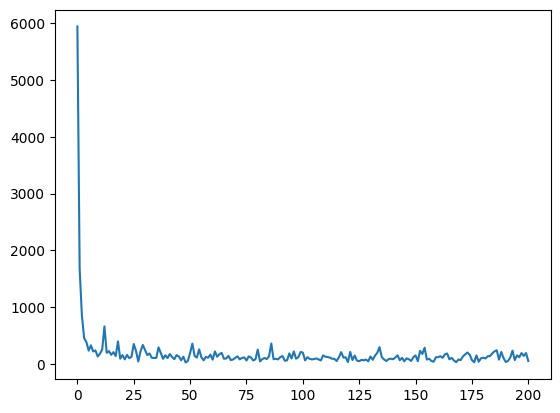

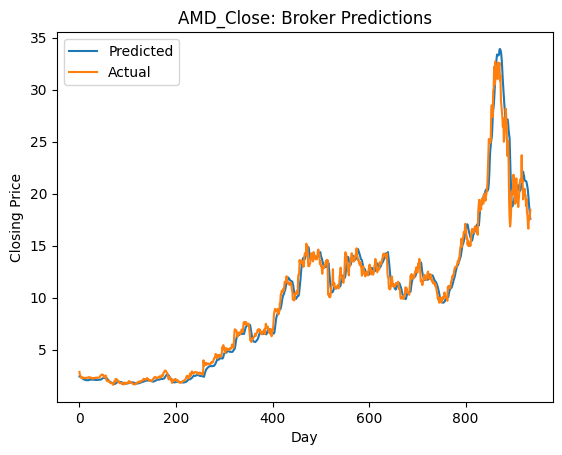

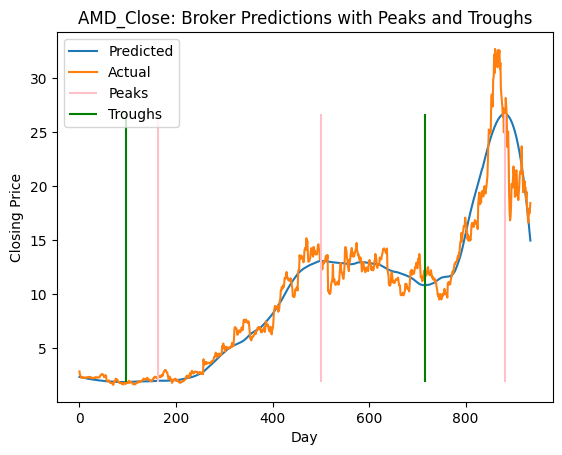

In [67]:
# Let's train a while bunch of models
epochs = 200
number_of_days = 20

# Just one stock
market = StockMarket([Stock("AMD")])
X_train, y_train, X_test, y_test, number_of_features = market.split(simple = market.enforce_timeframe("2000-01-01", "2019-01-01"))
Broker1 = DynamicModel(number_of_days = number_of_days, number_of_features = number_of_features - 1, hidden_size = 256, name = f"{len(market.stocks)}_stock_{number_of_days}_days", days_ahead=1)
Broker1.train(X_train, y_train, epochs)
Broker1.validate(X_test, y_test)
Broker1.save_summary()

Predicting: AMD_Close
Epoch: 200 Loss: 0.23123115301132202 Predicted:                                       4.3108649253845215 Actual: 3.829999923706054796
Training complete
Validation: 935/935
Accuracy: 0.47593582887700536
Model saved to ./summaries/8_stock_20_days/model.forsyth
Summary saved to ./summaries/8_stock_20_days


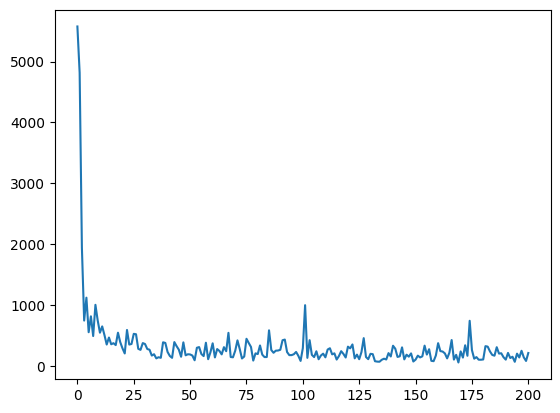

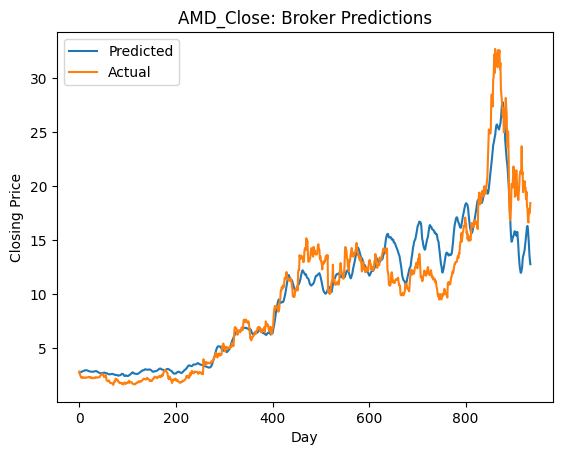

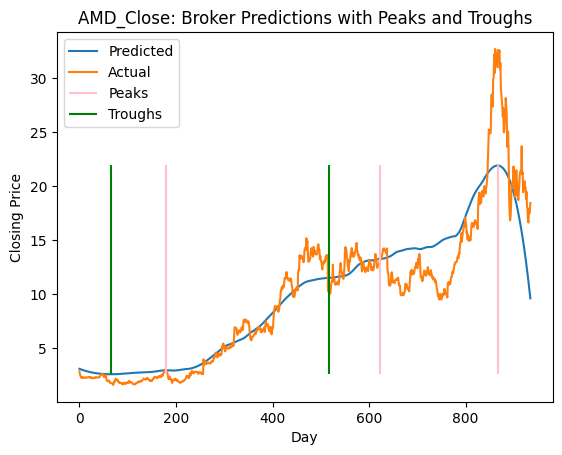

In [68]:
# Multiple stocks
market = StockMarket([Stock("TSM"), Stock("NVDA"), Stock("AAPL"), Stock("MSFT"), Stock("ORCL"), Stock("INTC"), Stock("IBM"), Stock("AMD")])
X_train, y_train, X_test, y_test, number_of_features = market.split(simple = market.enforce_timeframe("2000-01-01", "2019-01-01"))
Broker = DynamicModel(number_of_days = number_of_days, number_of_features = number_of_features - 1, hidden_size = 256, name = f"{len(market.stocks)}_stock_{number_of_days}_days", days_ahead=1)
Broker.train(X_train, y_train, epochs)
Broker.validate(X_test, y_test)
Broker.save_summary()

Predicting: AMD_Close
Epoch: 200 Loss: 1.4215925931930542 Predicted:                                       11.462306022644043 Actual: 10.270000457763672371
Training complete
Validation: 935/935
Accuracy: 0.32620320855614976
Model saved to ./summaries/9_stock_20_days/model.forsyth
Summary saved to ./summaries/9_stock_20_days


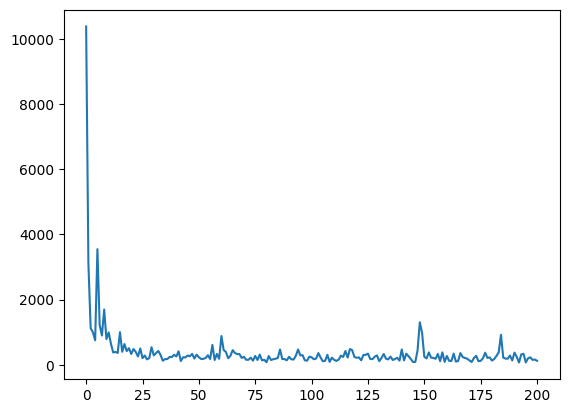

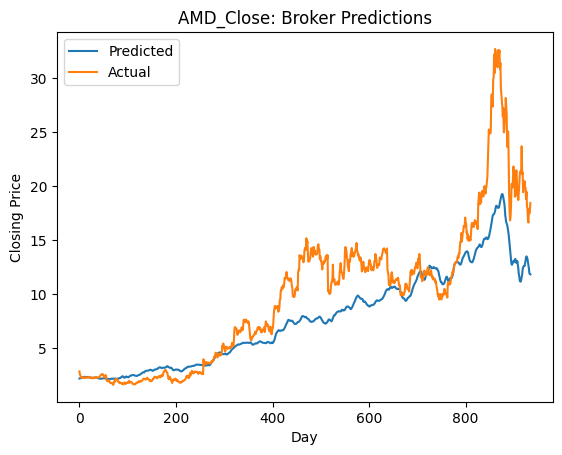

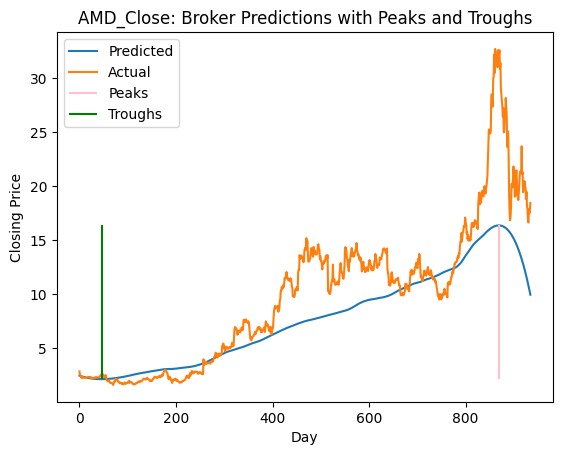

In [69]:
# More stocks
market = StockMarket([Stock("TSM"), Stock("NVDA"), Stock("AAPL"), Stock("MSFT"), Stock("ORCL"), Stock("INTC"), Stock("IBM"), Stock("AMZN"),  Stock("AMD")])
X_train, y_train, X_test, y_test, number_of_features = market.split(simple = market.enforce_timeframe("2000-01-01", "2019-01-01"))
Broker = DynamicModel(number_of_days = number_of_days, number_of_features = number_of_features - 1, hidden_size = 256, name = f"{len(market.stocks)}_stock_{number_of_days}_days", days_ahead=1)
Broker.train(X_train, y_train, epochs)
Broker.validate(X_test, y_test)
Broker.save_summary()

Predicting: AMD_Close
Epoch: 200 Loss: 9.108379364013672 Predicted:                                       18.521991729736328 Actual: 21.54000091552734465653
Training complete
Validation: 935/935
Accuracy: 0.0374331550802139
Model saved to ./summaries/9_stock_20_days/model.forsyth
Summary saved to ./summaries/9_stock_20_days


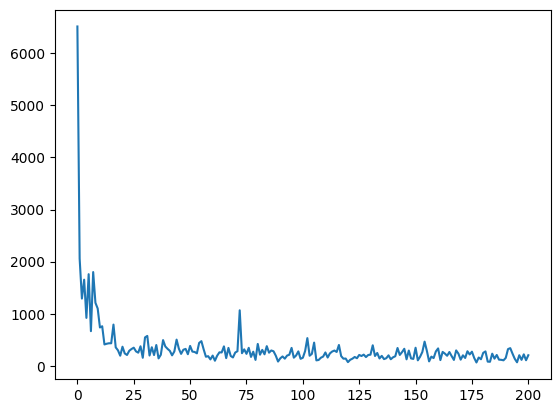

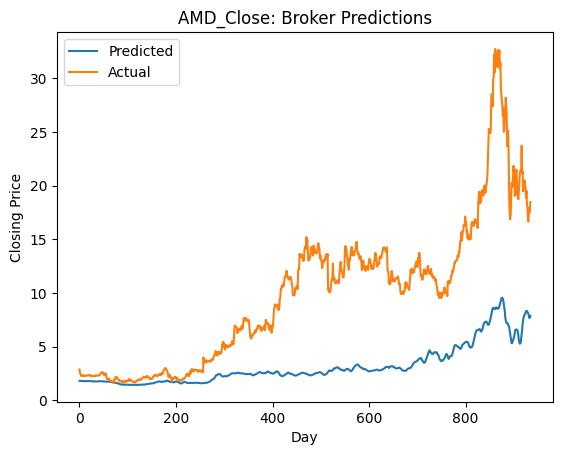

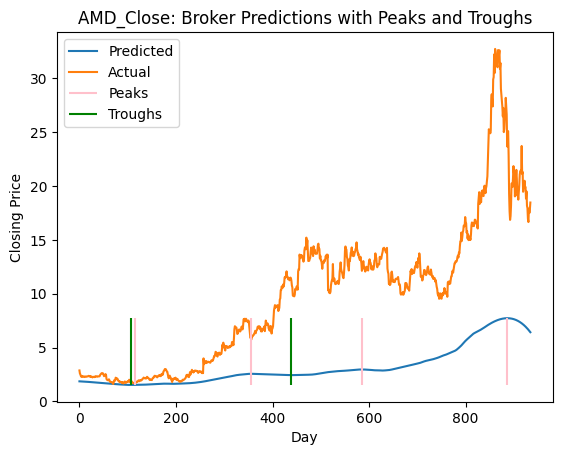

In [70]:
# Even more stocks
market = StockMarket([Stock("TSM"), Stock("NVDA"), Stock("AAPL"), Stock("MSFT"), Stock("ORCL"), Stock("INTC"), Stock("IBM"), Stock("AMZN"), Stock("AMD")])
X_train, y_train, X_test, y_test, number_of_features = market.split(simple = market.enforce_timeframe("2000-01-01", "2019-01-01"))
Broker = DynamicModel(number_of_days = number_of_days, number_of_features = number_of_features - 1, hidden_size = 256, name = f"{len(market.stocks)}_stock_{number_of_days}_days", days_ahead=1)
Broker.train(X_train, y_train, epochs)
Broker.validate(X_test, y_test)
Broker.save_summary()

Predicting: AMD_Close
Epoch: 200 Loss: 0.3444862961769104 Predicted:                                       3.4169294834136963 Actual: 2.8299999237060547738
Training complete
Validation: 935/935
Accuracy: 0.30267379679144385
Model saved to ./summaries/11_stock_20_days/model.forsyth
Summary saved to ./summaries/11_stock_20_days


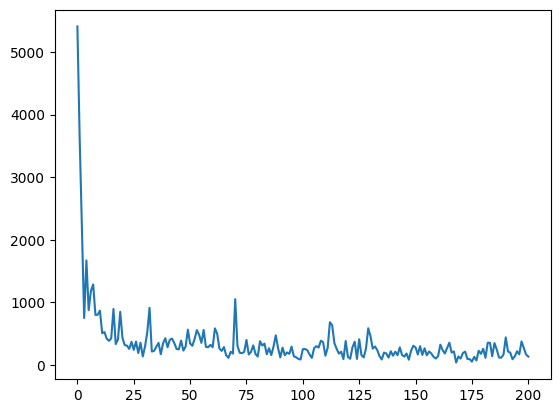

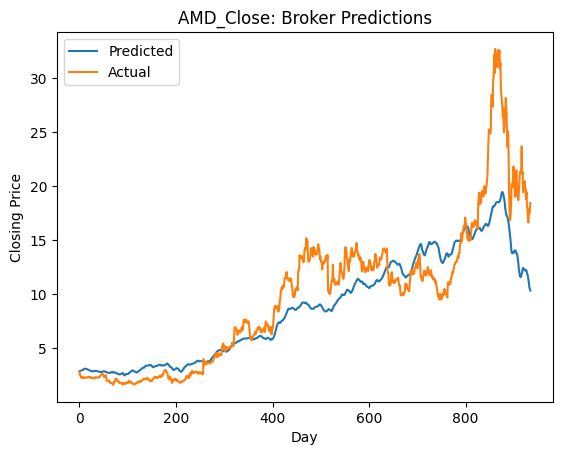

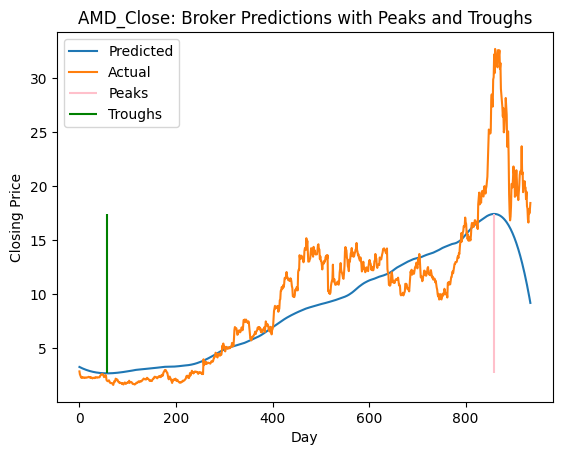

In [71]:
# Even more stocks
market = StockMarket([Stock("TSM"), Stock("NVDA"), Stock("AAPL"), Stock("MSFT"), Stock("ORCL"), Stock("INTC"), Stock("IBM"), Stock("AMZN"), Stock("CSCO"), Stock("QCOM"), Stock("AMD")])
X_train, y_train, X_test, y_test, number_of_features = market.split(simple = market.enforce_timeframe("2000-01-01", "2019-01-01"))
Broker = DynamicModel(number_of_days = number_of_days, number_of_features = number_of_features - 1, hidden_size = 256, name = f"{len(market.stocks)}_stock_{number_of_days}_days", days_ahead=1)
Broker.train(X_train, y_train, 200)
Broker.validate(X_test, y_test)
Broker.save_summary()